# Loading

In [26]:
import tobii_research as tr
from utils import *

def get_tracker():
  all_eyetrackers = tr.find_all_eyetrackers()

  for tracker in all_eyetrackers:
    print("Model: " + tracker.model)
    print("Serial number: " + tracker.serial_number) 
    print(f"Can stream eye images: {tr.CAPABILITY_HAS_EYE_IMAGES in tracker.device_capabilities}")
    print(f"Can stream gaze data: {tr.CAPABILITY_HAS_GAZE_DATA in tracker.device_capabilities}")
    return tracker

tracker = get_tracker()

data, dict = build_dataset(tracker, 'title')

data

Model: Tobii Pro Fusion
Serial number: TPFC6-010203104285
Can stream eye images: True
Can stream gaze data: True
{'device_time_stamp': 2274106202, 'system_time_stamp': 334460972138, 'left_gaze_point_on_display_area': (0.14785295724868774, 0.8519409894943237), 'left_gaze_point_in_user_coordinate_system': (-66.43907165527344, 24.52458381652832, -1.715612769126892), 'left_gaze_point_validity': 1, 'left_pupil_diameter': 6.015045166015625, 'left_pupil_validity': 1, 'left_gaze_origin_in_user_coordinate_system': (-54.17717742919922, -21.97833824157715, 658.1785888671875), 'left_gaze_origin_in_trackbox_coordinate_system': (0.6108813285827637, 0.5481580495834351, 0.4726289212703705), 'left_gaze_origin_validity': 1, 'right_gaze_point_on_display_area': (0.17787925899028778, 0.9081811308860779), 'right_gaze_point_in_user_coordinate_system': (-60.77405548095703, 18.29280662536621, -3.9837589263916016), 'right_gaze_point_validity': 1, 'right_pupil_diameter': 5.9630126953125, 'right_pupil_validity': 

,device_time_stamp,system_time_stamp,left_gaze_point_on_display_area,left_gaze_point_in_user_coordinate_system,left_gaze_point_validity,left_pupil_diameter,left_pupil_validity,left_gaze_origin_in_user_coordinate_system,left_gaze_origin_in_trackbox_coordinate_system,left_gaze_origin_validity,right_gaze_point_on_display_area,right_gaze_point_in_user_coordinate_system,right_gaze_point_validity,right_pupil_diameter,right_pupil_validity,right_gaze_origin_in_user_coordinate_system,right_gaze_origin_in_trackbox_coordinate_system,right_gaze_origin_validity,type
timestep_1,2274106202,334460972138,"(0.14785295724868774, 0.8519409894943237)","(-66.43907165527344, 24.52458381652832, -1.715...",1,6.015045,1,"(-54.17717742919922, -21.97833824157715, 658.1...","(0.6108813285827637, 0.5481580495834351, 0.472...",1,"(0.17787925899028778, 0.9081811308860779)","(-60.77405548095703, 18.29280662536621, -3.983...",1,5.963013,1,"(10.314059257507324, -22.409690856933594, 653....","(0.4788128733634949, 0.5487945675849915, 0.456...",1,title
timestep_2,2274597894,334461463826,"(0.15366758406162262, 0.836762547492981)","(-65.34203338623047, 26.206432342529297, -1.10...",1,6.027451,1,"(-54.45109939575195, -21.81670379638672, 658.1...","(0.6114406585693359, 0.5478289127349854, 0.472...",1,"(0.13742822408676147, 0.8744297027587891)","(-68.40589141845703, 22.032670974731445, -2.62...",1,5.968948,1,"(10.057084083557129, -22.297536849975586, 653....","(0.4793436527252197, 0.548565685749054, 0.4568...",1,title
timestep_3,2275106248,334461972176,"(0.2529779374599457, 0.8401217460632324)","(-46.60530090332031, 25.834224700927734, -1.23...",1,6.01651,1,"(-54.16535949707031, -21.68206024169922, 658.5...","(0.6107826232910156, 0.5475373864173889, 0.473...",1,"(0.2601988613605499, 0.847619354724884)","(-45.24293518066406, 25.003435134887695, -1.54...",1,6.069077,1,"(10.353081703186035, -22.298931121826172, 653....","(0.4787572920322418, 0.5485421419143677, 0.458...",1,title
timestep_4,2275614600,334462480523,"(0.4310128092765808, 0.6932687163352966)","(-13.015715599060059, 42.10649490356445, 4.683...",1,6.105057,1,"(-53.921043395996094, -20.839244842529297, 659...","(0.6101738214492798, 0.5457913279533386, 0.474...",1,"(0.45321768522262573, 0.7285130620002747)","(-8.826346397399902, 38.201202392578125, 3.262...",1,6.094437,1,"(10.570634841918945, -21.515270233154297, 654....","(0.47834357619285583, 0.5468997359275818, 0.46...",1,title
timestep_5,2276131289,334462997208,"(0.3958057463169098, 0.7029154896736145)","(-19.658185958862305, 41.037567138671875, 4.29...",1,6.19873,1,"(-54.41231155395508, -21.217453002929688, 658....","(0.6113125681877136, 0.5465923547744751, 0.473...",1,"(0.43747279047966003, 0.788970410823822)","(-11.796917915344238, 31.502134323120117, 0.82...",1,6.09729,1,"(10.117578506469727, -21.846004486083984, 653....","(0.47925347089767456, 0.5476036667823792, 0.45...",1,title
timestep_6,2276614649,334463480564,"(0.47841188311576843, 0.7041704058647156)","(-4.073008060455322, 40.898529052734375, 4.244...",1,6.110596,1,"(-54.929874420166016, -21.056285858154297, 657...","(0.6124719381332397, 0.5462834239006042, 0.472...",1,"(0.49995455145835876, 0.7649077773094177)","(-0.008577265776693821, 34.168418884277344, 1....",1,6.025238,1,"(9.622143745422363, -21.666257858276367, 653.4...","(0.4802609384059906, 0.5472521185874939, 0.457...",1,title
timestep_7,2277131345,334463997256,"(0.4626568853855133, 0.7171785235404968)","(-7.045475482940674, 39.45714569091797, 3.7194...",1,6.088043,1,"(-54.300132751464844, -20.745689392089844, 657...","(0.6111929416656494, 0.54564368724823, 0.47198...",1,"(0.4960635006427765, 0.7400633096694946)","(-0.7426948547363281, 36.92136001586914, 2.796...",1,6.006485,1,"(10.31446361541748, -21.817399978637695, 653.9...","(0.4788478910923004, 0.5475431680679321, 0.458...",1,title
timestep_8,2277631370,334464497277,"(0.6314547061920166, 0.6149827241897583)","(24.801359176635742, 50.78110122680664, 7.8410...",1,6.155273,1,"(-53.430320

In [7]:
# import time

# def gaze_data_callback(gaze_data):
#   global global_gaze_data
#   global_gaze_data = gaze_data
  
# def gaze_data(eyetracker, wait_time=5):
#   global global_gaze_data

#   print("Getting data...")
#   eyetracker.subscribe_to(tr.EYETRACKER_GAZE_DATA, gaze_data_callback, as_dictionary=True)

#   time.sleep(wait_time)

#   eyetracker.unsubscribe_from(tr.EYETRACKER_GAZE_DATA, gaze_data_callback)

#   return global_gaze_data
  
# data = gaze_data(tracker)
# data

Getting data...


{'device_time_stamp': 890952768,
 'system_time_stamp': 333077828558,
 'left_gaze_point_on_display_area': (0.17883707582950592,
  0.003639146452769637),
 'left_gaze_point_in_user_coordinate_system': (-60.59334182739258,
  118.52195739746094,
  32.49665832519531),
 'left_gaze_point_validity': 1,
 'left_pupil_diameter': 5.0716400146484375,
 'left_pupil_validity': 1,
 'left_gaze_origin_in_user_coordinate_system': (-192.70730590820312,
  -92.11940002441406,
  701.1041259765625),
 'left_gaze_origin_in_trackbox_coordinate_system': (0.8749958276748657,
  0.6833948493003845,
  0.6267613768577576),
 'left_gaze_origin_validity': 1,
 'right_gaze_point_on_display_area': (-0.013065677136182785,
  0.06947140395641327),
 'right_gaze_point_in_user_coordinate_system': (-96.79935455322266,
  111.22730255126953,
  29.841655731201172),
 'right_gaze_point_validity': 1,
 'right_pupil_diameter': 5.419677734375,
 'right_pupil_validity': 1,
 'right_gaze_origin_in_user_coordinate_system': (-129.60992431640625,
 

# Visualizations

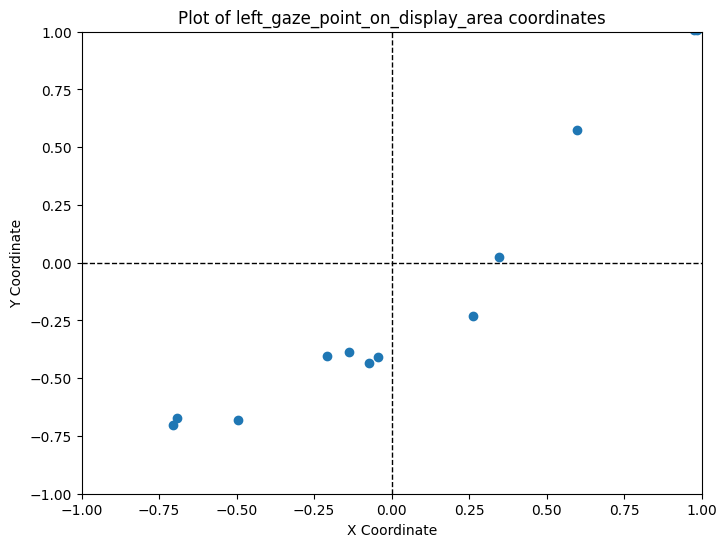

In [27]:
from matplotlib import pyplot as plt

# plot coordinates (you can use this for testing or for funsies)
# takes in a dataframe (call build_dataset first)
#          and a column_name (string)

def translate2ScreenX(xcoord):
    return 2*xcoord - 1

def translate2ScreenY(ycoord):
    return -2*ycoord + 1

def plot_coordinates(dataframe, column_name):
    # extract x and y coordinates from the specified column
    x_values = [point[0] for point in dataframe[column_name]]
    y_values = [point[1] for point in dataframe[column_name]]
    x_values = list(map(translate2ScreenX, x_values))
    y_values = list(map(translate2ScreenY, y_values))

    
    # plot the coordinates
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, marker='o', label=column_name)
    plt.title(f'Plot of {column_name} coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    plt.show()
    
plot_coordinates(data, 'left_gaze_point_on_display_area')


# Make eye detection functions

In [28]:
# example
# function should accept a dictionary of gaze data (look at what the gaze_data function returns)
# when we call build_dataset, we also make a call to gaze_data, so we'll be able to 
# modify build_dataset to check for movement detection at every timestep.

# things to consider:
# this sample code only takes in one row/timestep
# if we want to use acceleration or speed of eye movements,
# we need to look at multiple rows at a time



def detect_movement_example(data_dict):
    # data_dict should only have 1 row
    assert(len(data_dict) == 1)  # remove this in practice, just keeping it here for initial testing
    
    # get the first (and only) row in data_dict
    eye_data = data_dict.iloc[0]
    
    # get eye coordinates
    left_x, left_y = data.left_gaze_point_on_display_area[0]
    right_x, right_y = data.right_gaze_point_on_display_area[0]
    
    # do some kind of detection
    print(left_x)
    if (left_x < -0.8): data_dict = "turnLeft"
    elif (left_x > 0.8): data_dict = "turnRight"
    if (left_y < -0.8): data_dict = "forward"
    elif ( )
    return (left_x >= 0)
    
# test your function
data2 = pd.DataFrame(data.iloc[0]).transpose()  # call build_dataset and get a row
detect_movement_example(data2)                  # call detect_movement


0.14785295724868774


True

In [ ]:
# functions
# left
# right
# up 
# down
# eye roll

In [1]:
# try incorporating your function into a modified build_dataset, 
# so you can test your movement detection function while recording data

# make modifications here:
def modified_build_dataset(tracker, label, add_on = False, df_orig = pd.DataFrame(), 
                  time_step_sec = 0.5, tot_time_min = 0.1):
    
    global global_gaze_data
    
    intervals = math.ceil((tot_time_min * 60) / time_step_sec)
    dict_list = []
    
    for _ in range(intervals):
        data = gaze_data(tracker, time_step_sec)
        dict_list.append(data)
    
    tot_dict = combine_dicts_with_labels(dict_list)
    df = pd.DataFrame(tot_dict).T
    df['type'] = label
        
    if add_on:
        df_new = pd.concat([df_orig, df])
        df_new = df_new.reset_index(drop=True)
        return df_new
    
    else:
        return df, dict_list

NameError: name 'pd' is not defined